## INTRODUÇÃO

Esse projeto visa a construção de um modelo de classificação de churn, utilizando a técnica SMOTE para o tratamento de classes desbalanceadas e Grid Search para a otimização dos hiperparâmetros dos modelos Decision Tree Classifier e Random Forest Classifier. 

Em resumo, churn é a medida da quantidade de clientes que deixam de fazer negócios com uma empresa, geralmente expressa como uma porcentagem do total de clientes ativos. Uma alta taxa de churn pode indicar problemas na qualidade do produto ou serviço, atendimento ao cliente, concorrência acirrada, entre outros fatores, e pode afetar negativamente a saúde financeira da empresa.
Nesse sentido, é importante que as empresas consigam identificar clientes que potencialmente podem "dar churn" para que possam tomar medidas para estimular a retenção desse tipo de cliente.

Para essa análise, utilizaremos um dataset com dados de clientes de um banco. Ele pode ser encontrado neste link: https://www.kaggle.com/datasets/gauravtopre/bank-customer-churn-dataset



### Features

In [1]:
#Manipulação e visualização de de dados
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
plt.style.use('ggplot')

#Construção e avaliação de modelos
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score, roc_curve, auc
from sklearn.metrics import roc_auc_score, precision_score, make_scorer
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.base import clone

#Modelos
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

#Pré-processamento
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

## Dataset

In [2]:
df = pd.read_csv('Bank Customer Churn Prediction.csv')

df.head()

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [3]:
df.shape

(10000, 12)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       10000 non-null  int64  
 1   credit_score      10000 non-null  int64  
 2   country           10000 non-null  object 
 3   gender            10000 non-null  object 
 4   age               10000 non-null  int64  
 5   tenure            10000 non-null  int64  
 6   balance           10000 non-null  float64
 7   products_number   10000 non-null  int64  
 8   credit_card       10000 non-null  int64  
 9   active_member     10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


### Estatísticas Descritivas

In [5]:
df.describe()

,customer_id,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


<AxesSubplot: >

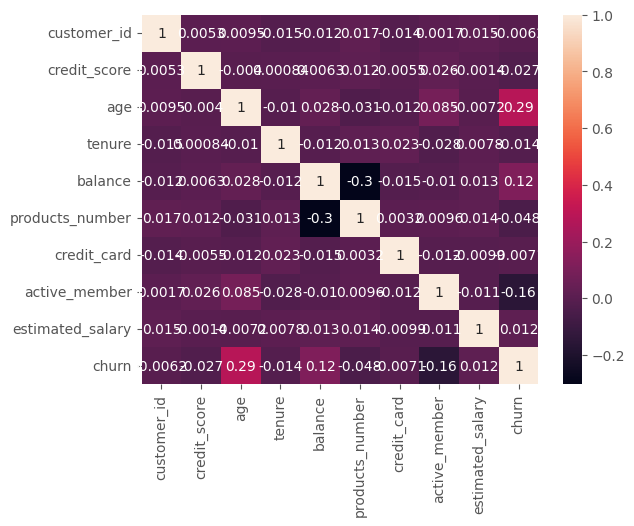

In [6]:
sns.heatmap(df.corr(numeric_only = True), annot = True)

Através do mapa de calor das correlações entre as variáveis, podemos ver que existem poucas correlações (positivas ou negativas) com alto nível de significância. 

Com relação ao churn, vemos que existem uma pequena correlação positiva com a variável "age", o que indica uma certa tendência de churn para pessoas mais velhas. Além de uma pequena correlação negativa entre a variável churn e a variável "active_member", que, naturalmente, indica uma correlação negativa entre a atividade do cliente e o churn (quanto menos a atividade na conta bancária, maior a chance de churn).

In [7]:
df.nunique()

customer_id         10000
credit_score          460
country                 3
gender                  2
age                    70
tenure                 11
balance              6382
products_number         4
credit_card             2
active_member           2
estimated_salary     9999
churn                   2
dtype: int64

### EDA

In [8]:
#Removendo coluna de id
df.drop('customer_id', 1,  inplace = True)

df.head()

C:\Users\joaoi\AppData\Local\Temp\ipykernel_8580\1752265393.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop('customer_id', 1,  inplace = True)


,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [9]:
#Organizando as variaveis para a análise gráfica
cat_vars = ['country', 'gender']
num_vars = ['credit_score', 'age', 'tenure', 'balance', 'estimated_salary']
dist_vars = ['products_number', 'credit_card', 'active_member']

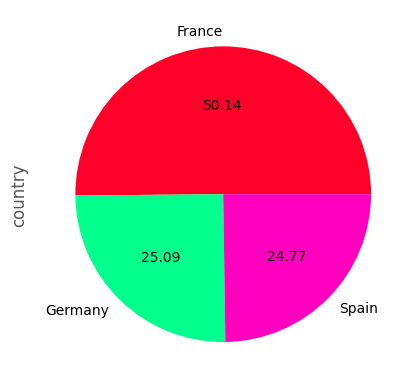

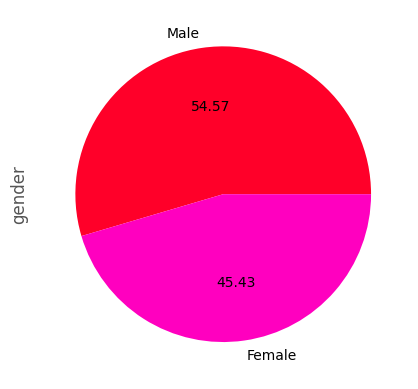

In [10]:
for k in cat_vars:
    df[k].value_counts().plot(kind='pie', autopct = "%.2f", cmap = 'gist_rainbow')
    plt.show()

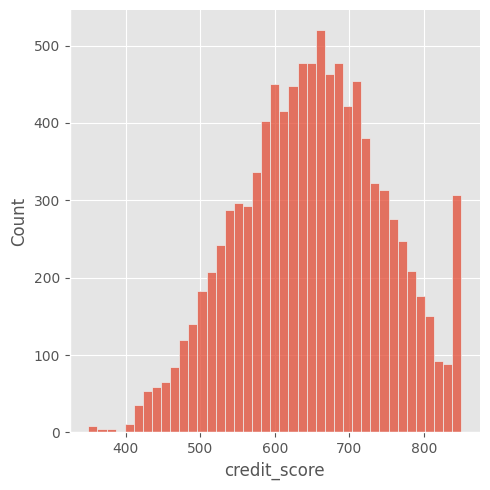

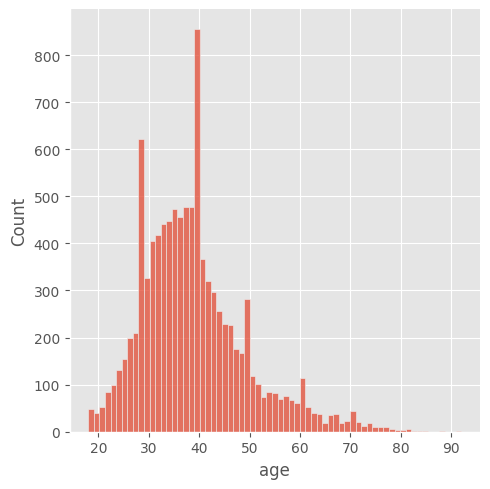

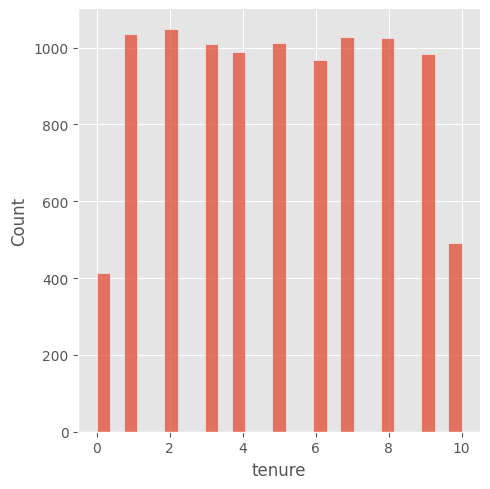

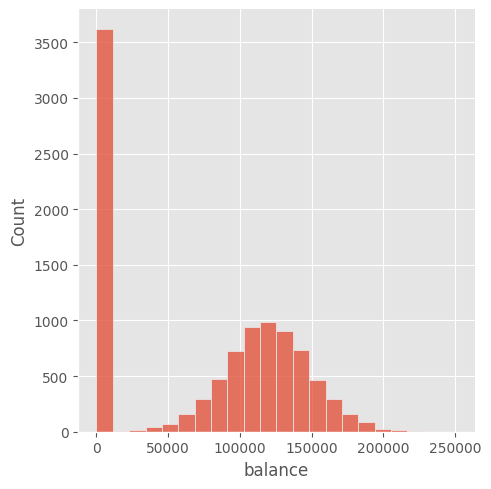

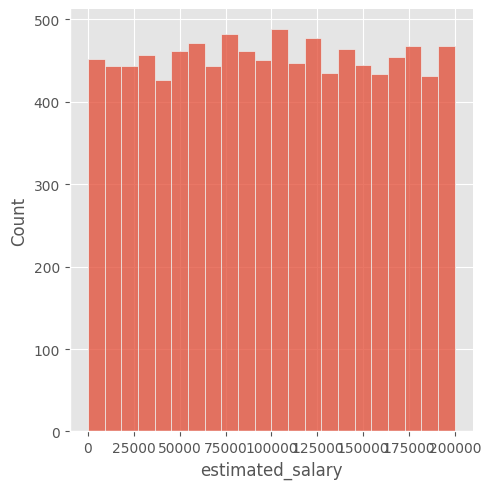

In [11]:
for i in num_vars:
    sns.displot(df[i])
    plt.show()

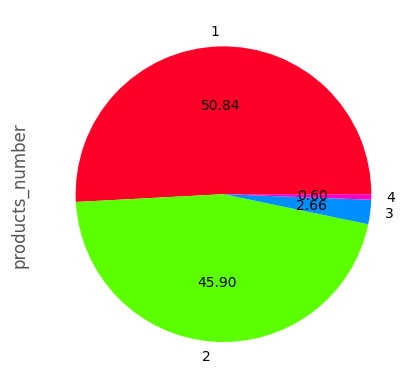

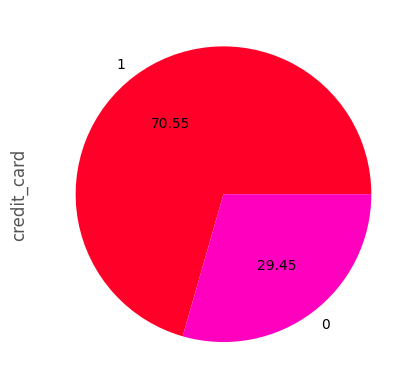

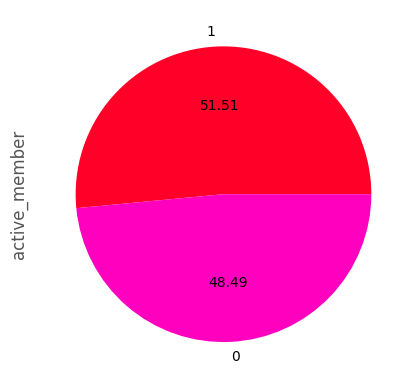

In [12]:
for j in dist_vars:
    df[j].value_counts().plot(kind='pie', autopct = "%.2f", cmap = 'gist_rainbow')
    plt.show()

## Pré-Processamento

### Features:

In [13]:
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = np.random.randint(0, 1000))

In [15]:
# Criando dataframes para verificar a quantidade de registros de cada classe
y_test_df = pd.DataFrame(y_test)
y_train_df = pd.DataFrame(y_train)

print('y_train',y_train_df.value_counts())

print('y_test',y_test_df.value_counts())


y_train 0    6368
1    1632
dtype: int64
y_test 0    1595
1     405
dtype: int64


Como podemos ver, existe uma discrepância entre a quantidade de classes 1 (churn) e 0 (não churn). Isso é ruim porque o modelo tem muitos exemplos da classe 0 e poucos da classe 1, fazendo com que ele tenha mais dificuldades em capturar os padrões dos registros de classe 1, prejudicando sua capacidade de previsão para esse tipo de classe.

Para resolver esse problema, iremos aplicar, após a transformação dos dados, a técnica SMOTE para equilibrar a quantidade de registros para cada classe.

### Feature Scaling e OneHotEncoding

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   credit_score      10000 non-null  int64  
 1   country           10000 non-null  object 
 2   gender            10000 non-null  object 
 3   age               10000 non-null  int64  
 4   tenure            10000 non-null  int64  
 5   balance           10000 non-null  float64
 6   products_number   10000 non-null  int64  
 7   credit_card       10000 non-null  int64  
 8   active_member     10000 non-null  int64  
 9   estimated_salary  10000 non-null  float64
 10  churn             10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


Com base na análise das variáveis e suas distribuições, aplicaremos a função "MinMaxScaler()" nas colunas numéricas para diminuir a variabilidade delas, o que prejudicaria a capacidade preditiva do modelo.

In [17]:
cat_cols_idx = [1, 2] #country e gender
num_cols_idx = [0, 3, 4, 5, 9] #credit_score, age,tenure,  balance, estimated_salary

#Pipeline para colunas categóricas
cat_pipeline = Pipeline([
    ('one_hot_encoder', OneHotEncoder(handle_unknown = 'ignore'))
])

#Pipeline para colunas numéricas 
num_pipeline = Pipeline([
    ('scaler', MinMaxScaler())
])

#Aplicando as pipelines
ct = ColumnTransformer([
    ('categorical', cat_pipeline, cat_cols_idx),
    ('numerical', num_pipeline, num_cols_idx)
], remainder = 'passthrough')

X_train = ct.fit_transform(X_train)
X_test = ct.transform(X_test)

X_train = X_train.astype(float)
X_test = X_test.astype(float)

## Construindo modelos

## Decision Tree Classifier

### Grid Search

O Grid Search é uma técnica de otimização de hiperparâmetros, em que o objetivo é encontrar a combinação ideal de hiperparâmetros que resulte no melhor desempenho do modelo.

O Grid Search funciona criando uma grade de todas as combinações possíveis de valores para os hiperparâmetros que se deseja otimizar. Em seguida, o modelo é treinado e avaliado para cada combinação de hiperparâmetros na grade, usando uma estratégia de validação cruzada. Por fim, o conjunto de hiperparâmetros que resulta no melhor desempenho é escolhido como o conjunto ótimo para o modelo.

Nesse caso, utilizarei a métrica de recall, ou seja, o Grid Search vai procurar por hiperparâmetros que proporcionem um recall maior para o modelo. Dessa forma o modelo conseguirá prever melhor os valores positivos (1), que é o principal objetivo.

In [18]:
dec_tree = DecisionTreeClassifier()

param_grid = [{'max_depth': [2, 3, 4], 'class_weight':['balanced'], 'criterion':['gini', 'entropy']
               , 'min_samples_split' : [300, 500, 700, 1000, 3000]}]

grid_search = GridSearchCV(dec_tree, param_grid, cv = 5, scoring = 'recall')

grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid=[{'class_weight': ['balanced'],
                          'criterion': ['gini', 'entropy'],
                          'max_depth': [2, 3, 4],
                          'min_samples_split': [300, 500, 700, 1000, 3000]}],
             scoring='recall')

In [19]:
print("Parâmetros recomendados:", grid_search.best_params_)
print("Recall médio do melhor conjunto de parâmetros encontrado:", grid_search.best_score_)

Parâmetros recomendados: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 4, 'min_samples_split': 300}
Recall médio do melhor conjunto de parâmetros encontrado: 0.7561246505694077


Aqui vemos os hiperparâmetros que fazem o recall ser o maior possível, segundo o Grid Search: 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 4, 'min_samples_split': 300

In [20]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(mean_score), params)

0.8179945146420624 {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 2, 'min_samples_split': 300}
0.8179945146420624 {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 2, 'min_samples_split': 500}
0.8179945146420624 {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 2, 'min_samples_split': 700}
0.8179945146420624 {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 2, 'min_samples_split': 1000}
0.8179945146420624 {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 2, 'min_samples_split': 3000}
0.8134947451003052 {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 300}
0.8134947451003052 {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 500}
0.8134947451003052 {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 700}
0.8134947451003052 {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 1000

### SMOTE

O algoritmo SMOTE (Synthetic Minority Over-sampling Technique) é uma técnica de aumento de dados que ajuda a lidar com conjuntos de dados desequilibrados. Em outras palavras, quando temos muito mais exemplos de uma classe em comparação com outra classe em um conjunto de dados.

O SMOTE trabalha criando novos exemplos sintéticos da classe minoritária, em vez de simplesmente repetir os exemplos existentes. Ele faz isso selecionando aleatoriamente exemplos da classe minoritária e criando novos exemplos artificiais interpolando suas características com as características de seus vizinhos próximos. Isso ajuda a aumentar a quantidade de dados da classe minoritária, tornando o conjunto de dados mais balanceado e ajudando a melhorar o desempenho do modelo de aprendizado de máquina.

O Algoritmo smote funciona através de 5 passos:

1. Extrai uma amostra aleatória da classe minoritária.

2. Identifica os K (valor definido anteriormente) vizinhos mais próximos da amostra.

3. Escolhe um desses viznhos e identifica o vetor que liga o ponto de dados atual e o vizinho selecionado.

4. Multiplica o vetor por um número aleatório entre 0 e 1 e adiciona o resultado ao ponto de dados atual para o obter um ponto de dados sintético.

5. Repete as etapas 1-4 até que os dados estejam balanceados. O objetivo é criar novos pontos sintéticos suficientes para alcançar o nível desejado de equilíbrio entre as classes minoritárias e majoritárias.

In [21]:
# Define pipeline com utilização do SMOTE e criação do modelo
steps = [('over', SMOTE()), ('model', DecisionTreeClassifier(criterion='entropy', max_depth =4
                , random_state = np.random.randint(0, 1000), class_weight = 'balanced', min_samples_split = 300
                                                            ))]
pipeline = Pipeline(steps=steps)

### Cross-validation Estratificado

Para avaliar o modelo através do cross-validation usando o SMOTE, é necessário aplicá-lo em cada fold. 

Nesse caso, usei também a função 'RepeatedStratifiedKFold' para nos certificarmos de que as classes vão estar balanceadas dentro de cada fold do cross-validation.

In [22]:
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=np.random.randint(0, 1000))
rec_scores = cross_val_score(pipeline, X_train, y_train, scoring='recall', cv=cv, n_jobs=-1)

# Calcular a média e o desvio padrão dos valores de recall
rec_mean = rec_scores.mean()
rec_std = rec_scores.std()

# Retornar o resultado formatado
result = "Recall: {:.2f} (+/- {:.2f})\nrec_scores: {}".format(rec_mean, rec_std, rec_scores)
print(result)


Recall: 0.70 (+/- 0.03)
rec_scores: [0.65337423 0.70552147 0.75153374 0.68195719 0.71253823]


In [23]:
# Treinando e avaliando o modelo sem cross-validation
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

# Métricas de avaliação do modelo
acuracia = accuracy_score(y_test, y_pred)
auc_area = roc_auc_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)

print('Acurácia:', round(acuracia, 2))
print('Recall:', round(recall, 2))
print('Precision:', round(precision, 2))
print('Especificidade:', round(specificity, 2))
print('AUC', round(auc_area, 2))

Acurácia: 0.67
Recall: 0.8
Precision: 0.36
Especificidade: 0.63
AUC 0.71


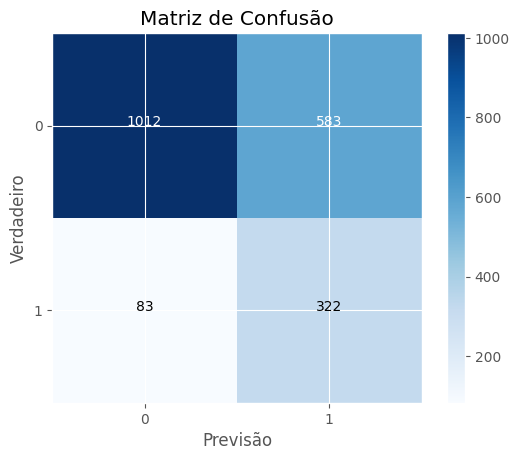

In [24]:
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Matriz de Confusão')
plt.colorbar()

classes = ['0', '1']
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.xlabel('Previsão')
plt.ylabel('Verdadeiro')

plt.show()

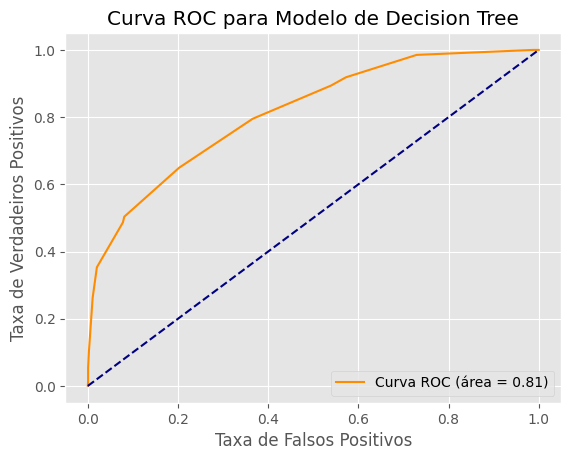

In [25]:
# Obter as probabilidades previstas para a classe positiva
y_proba = pipeline.predict_proba(X_test)[:, 1]

# Calcular a curva ROC e a área sob a curva (AUC)
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', label='Curva ROC (área = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC para Modelo de Decision Tree')
plt.legend(loc="lower right")
plt.show()

## Random Forest Classifier

### Grid Search

In [26]:
forest_reg = RandomForestClassifier()

param_grid = [{'n_estimators' : [30, 75, 100, 200], 'max_depth': [2, 3, 5]
               ,'criterion':['gini', 'entropy'], 'class_weight': ['balanced']
               , 'min_samples_split' : [300, 500, 700, 1000, 3000]}]

grid_search = GridSearchCV(forest_reg, param_grid, cv = 5, scoring = 'recall')

grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid=[{'class_weight': ['balanced'],
                          'criterion': ['gini', 'entropy'],
                          'max_depth': [2, 3, 5],
                          'min_samples_split': [300, 500, 700, 1000, 3000],
                          'n_estimators': [30, 75, 100, 200]}],
             scoring='recall')

In [27]:
print("Parâmetros recomendados:", grid_search.best_params_)
print("Recall médio do melhor conjunto de parâmetros encontrado:", grid_search.best_score_)

Parâmetros recomendados: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 1000, 'n_estimators': 30}
Recall médio do melhor conjunto de parâmetros encontrado: 0.7658955741918538


Para o algoritmo de Random Forest, os melhores hiperparâmetros selecionados pelo Grid Search foram: 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 1000, 'n_estimators': 30 

In [28]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(mean_score), params)

0.8542682837784515 {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 2, 'min_samples_split': 300, 'n_estimators': 30}
0.8452603264190401 {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 2, 'min_samples_split': 300, 'n_estimators': 75}
0.8466918641466578 {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 2, 'min_samples_split': 300, 'n_estimators': 100}
0.8492340528831992 {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 2, 'min_samples_split': 300, 'n_estimators': 200}
0.8354078229537554 {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 2, 'min_samples_split': 500, 'n_estimators': 30}
0.8467073749152411 {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 2, 'min_samples_split': 500, 'n_estimators': 75}
0.8466929720681227 {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 2, 'min_samples_split': 500, 'n_estimators': 100}
0.8503202901179034 {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth'

In [42]:
# Define pipeline com utilização do SMOTE e criação do modelo
steps2 = [('over', SMOTE()), ('model', RandomForestClassifier(max_depth =3, n_estimators = 100
                             , random_state = np.random.randint(0, 1000), criterion = 'gini'
                            , class_weight = 'balanced', min_samples_split = 1000))]

pipeline2 = Pipeline(steps=steps2)

### Cross-validation Estratificado

In [43]:
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=np.random.randint(0, 1000))
rec_scores = cross_val_score(pipeline, X_train, y_train, scoring='recall', cv=cv, n_jobs=-1)

# Calcular a média e o desvio padrão dos valores de recall
rec_mean = rec_scores.mean()
rec_std = rec_scores.std()

# Retornar o resultado formatado
result = "Recall: {:.2f} (+/- {:.2f})\nrec_scores: {}".format(rec_mean, rec_std, rec_scores)
print(result)

Recall: 0.74 (+/- 0.06)
rec_scores: [0.7791411  0.76993865 0.71165644 0.62996942 0.80428135]


In [44]:
# Treinando e avaliando o modelo sem cross-validation
pipeline2.fit(X_train, y_train)
y_pred2 = pipeline2.predict(X_test)

# Métricas de avaliação do modelo
acuracia = accuracy_score(y_test, y_pred2)
auc_area = roc_auc_score(y_test, y_pred2)
cm = confusion_matrix(y_test, y_pred2)
recall = recall_score(y_test, y_pred2)
precision = precision_score(y_test, y_pred2)
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)

print('Acurácia:', round(acuracia, 2))
print('Recall:', round(recall, 2))
print('Precision:', round(precision, 2))
print('Especificidade:', round(specificity, 2))

Acurácia: 0.76
Recall: 0.71
Precision: 0.45
Especificidade: 0.78


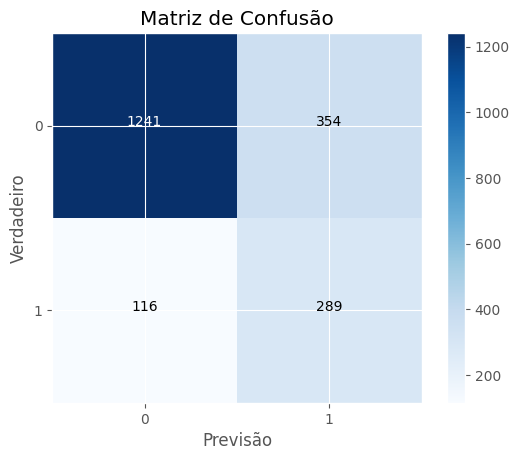

In [45]:
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Matriz de Confusão')
plt.colorbar()

classes = ['0', '1']
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.xlabel('Previsão')
plt.ylabel('Verdadeiro')

plt.show()

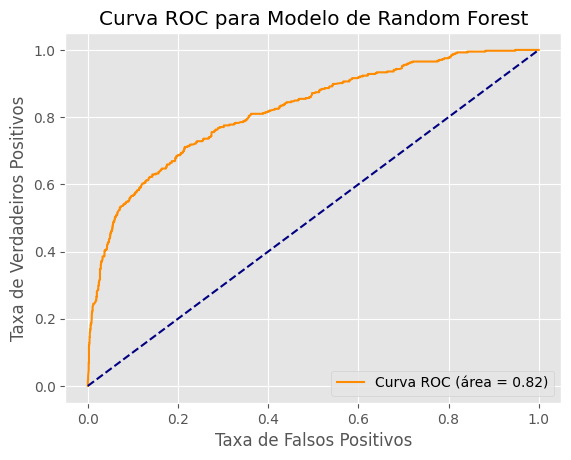

In [46]:
# Obter as probabilidades previstas para a classe positiva
y_proba =pipeline2.predict_proba(X_test)[:, 1]

# Calcular a curva ROC e a área sob a curva (AUC)
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', label='Curva ROC (área = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC para Modelo de Random Forest')
plt.legend(loc="lower right")
plt.show()

## Conclusão

A utilização do SMOTE melhorou o desempenho do modelo, no entanto, é necessário ter cuidado na sua utilização, pois pode facilmente gerar problemas de overfitting, especialmente na aplicação de cross-validation.

O Grid Search auxilia bastante na escolhas dos hiperparâmetros dos modelos, no entanto, nem sempre o modelo tem o melhor desempenho com os valores indicados por ele. Isso acontece pelo fato da diferença entre os desempenhos do modelo com diferentes valores de hiperparâmetros não seja tão grande, fazendo com que aleatoriamente o modelo tenha um desempenho melhor para certos valores que, na prática, não necessariamente são superiores aos outros.

No mais, essas duas técnicas ajudam bastante na construção de bons modelos de machine learning, e é certamente bem útil para quem trabalha com machine learning saber como elas funcionam e utilizá-las da maneira correta para tê-las no seu repertório.

Obrigado por ler! :)